In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
def get_FPU_func(alpha, beta):
    def FPU(r):
        # r_abs = np.abs(r)
        try:
            # return r_abs**2/2 lpha*r_abs**3/3+beta*r_abs**4/4
            return r**2/2 + alpha*r**3/3+beta*r**4/4
        except:
            print('ERROR', r)
    return FPU

def get_FPU_der(alpha, beta):
    def FPU_der(r):
        # r_abs = np.abs(r)
        try:
            # return r_abs*(1 + alpha*r_abs+beta*r_abs**2)
            return r*(1 + alpha*r+beta*r**2)
        except:
            print('ERROR', r)
    return FPU_der

In [4]:
m = 1
a = 1

In [5]:
alpha = 0.8
beta = 0.3

In [6]:
dt = 0.01
k = 1000000 # время 134041
k_arr = [1, 10, 100, 1000, 10000, 100000, 1000000]
t_end = k*dt
n = 100 # точки

In [7]:
I = 11
q = 0.01*I

In [8]:
FPU = get_FPU_func(alpha, beta)
FPU_der = get_FPU_der(alpha, beta)

### Расчёт с помощью обычного Алгоритма Верле

Для проверки формул и алгоритма

In [9]:
q_init = np.zeros(2*n+2)
v_init = np.zeros(2*n+2)
a_init = np.zeros(2*n+2)

In [10]:
q_init[n] -= q
q_init[n+1] += q

In [11]:
a_init[1:-1] = -(-FPU_der(q_init[1:-1]-q_init[2:])+FPU_der(q_init[:-2]-q_init[1:-1]))/m
a_init[[0,-1]] = a_init[[-2,1]]

In [12]:
q_cur = q_init
v_cur = v_init
a_cur = a_init

In [13]:
start_model = False

In [14]:
if start_model:
    for i in tqdm(range(k)):
        q_cur = q_cur + v_cur*dt+0.5*a_cur*dt**2
        v_half = v_cur + 0.5 * a_cur*dt
        a_cur[1:-1] = -(-FPU_der(q_cur[:-2]-q_cur[1:-1])
                            +FPU_der(q_cur[1:-1]-q_cur[2:]))/m
        a_cur[[0,-1]] = a_cur[[-2,1]]
        v_cur = v_half + 0.5*a_cur*dt
        assert not np.any(np.isnan(q_cur)), 'q_nan'
        assert not np.any(np.isnan(v_cur)), 'v_nan'
        assert not np.any(np.isnan(a_cur)), 'a_nan'
        assert not np.any(np.isinf(q_cur)), 'q_inf'
        assert not np.any(np.isinf(v_cur)), 'v_inf'
        assert not np.any(np.isinf(a_cur)), 'a_inf'
        assert q_cur[0] == q_cur[-2], f'q0[{i}]:{(q_cur[0],  q_cur[-2])}'
        assert q_cur[1] == q_cur[-1], f'q1[{i}]:{(q_cur[1],  q_cur[-1])}'
        assert v_cur[0] == v_cur[-2], f'v0[{i}]:{(v_cur[0],  v_cur[-2])}'
        assert v_cur[1] == v_cur[-1], f'v1[{i}]:{(v_cur[1],  v_cur[-1])}'

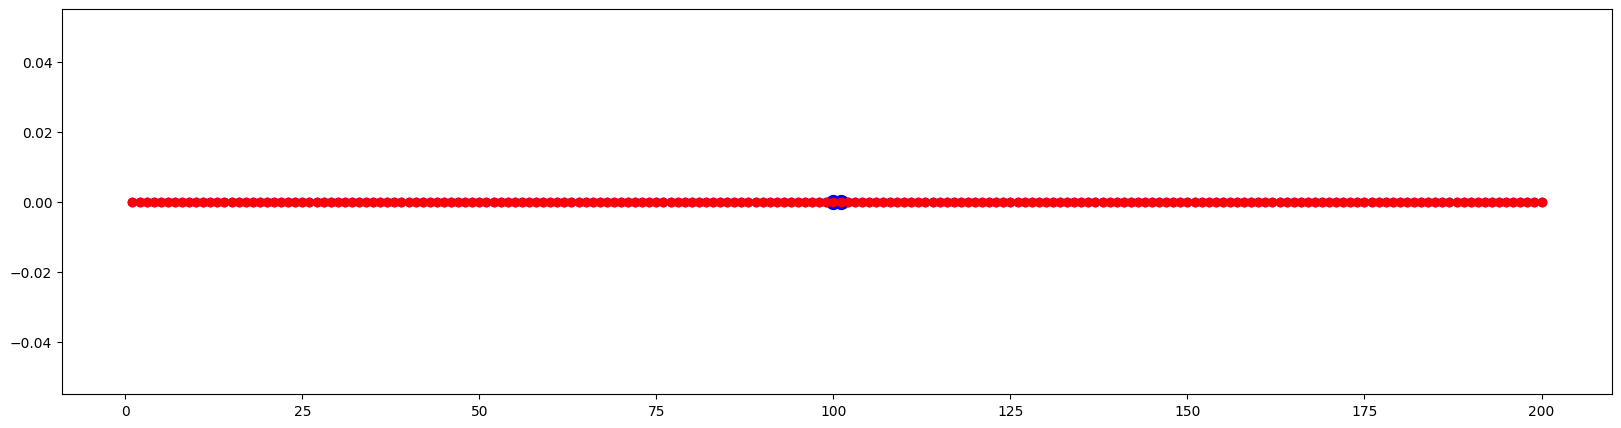

In [15]:
plt.figure(figsize=(20,5))
plt.scatter(q_init[1:-1]+np.arange(1,2*n+1)*a, np.zeros(2*n), c='b')
plt.scatter(q_init[[n,n+1]]+[n*a, (n+1)*a], np.zeros(2), s=100, c='b')
plt.scatter(q_cur[1:-1]+np.arange(1,2*n+1)*a, np.zeros(2*n), c='r')
# plt.scatter(q_init[1:-1]+np.arange(1,2*n+1)*a, q_cur[1:-1], c='r')
plt.show()

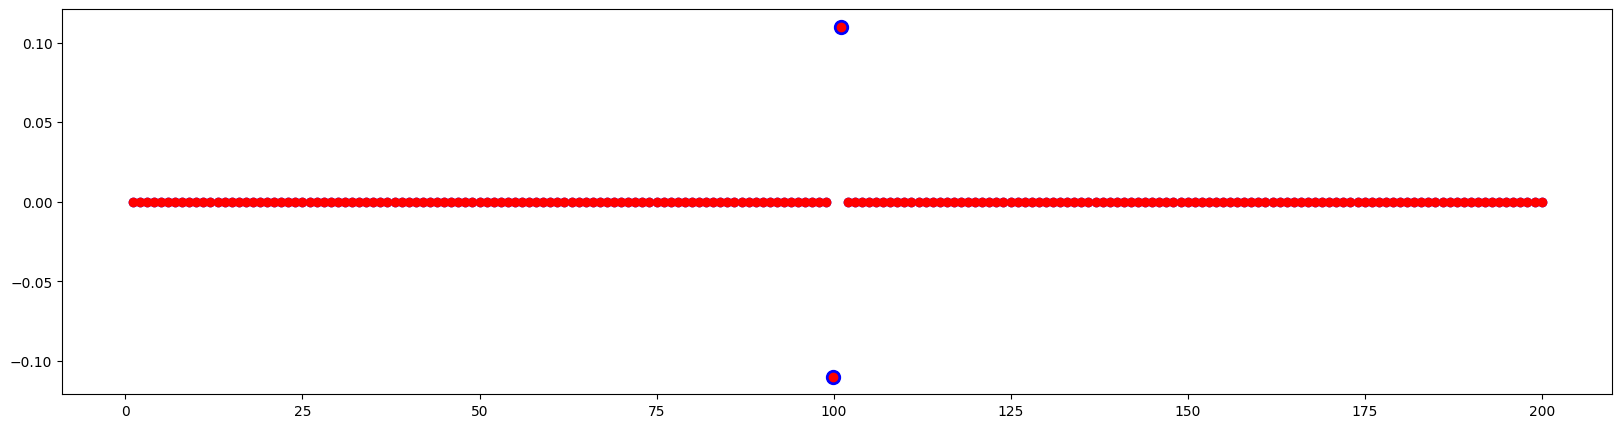

In [16]:
plt.figure(figsize=(20,5))
plt.scatter(q_init[1:-1]+np.arange(1,2*n+1)*a, q_init[1:-1], c='b')
plt.scatter(q_init[[n,n+1]]+[n*a, (n+1)*a], q_init[[n,n+1]], s=100, c='b')
plt.scatter(q_init[1:-1]+np.arange(1,2*n+1)*a, q_cur[1:-1], c='r')
plt.show()

In [17]:
# q_cur

### Графики по посчитанным данным

Рассчёт был сделан с помощью программы на C++.

In [18]:
import pandas as pd

In [23]:
df_smp = pd.read_csv('results\\1e8_SIMPLEX_res.out', index_col=False)

In [24]:
q_init[100]

-0.11

In [25]:
energy_0 = np.sum(FPU(q_init[2:] - q_init[1:-1] ))
energy_0

0.0386272535

In [26]:
_df_smp = df_smp.q_0.to_numpy()

In [27]:
np.sum(FPU(_df_smp[1:] - _df_smp[:-1])) + FPU(_df_smp[-1] - _df_smp[0] )

0.0386272535

In [28]:
checkp_cnt = (df_smp.shape[1]-1)//2

In [29]:
pd.read_csv('./results/1e8_SIMPLEX_energy.out', header=None)

,0
0,0.038627
1,0.038627
2,0.038627
3,0.038627
4,0.038627
5,0.038627
6,0.038627
7,0.038627
8,0.038627
9,0.038627


In [30]:
(df_smp.v_0 < 0).any()

False

In [33]:
for i in range(checkp_cnt):
    energy_calc_smp = np.sum(FPU(df_smp[f'q_{i}'].values[1:] - df_smp[f'q_{i}'].values[:-1]))
    energy_calc_smp += FPU(df_smp[f'q_{i}'].values[-1] - df_smp[f'q_{i}'].values[0])
    print(f'{int(10**(i-1)):10}', end=' ')
    kin_en = np.sum(df_smp[f'v_{i}'].values**2) * 0.5
    print(f'{kin_en:24}', end=' ')
    energy_calc_smp += kin_en
    print(energy_0, f'{energy_calc_smp:20}', energy_0 - energy_calc_smp)
    if i == 0:
        energy_0 = energy_calc_smp

         0                      0.0 0.0386272535         0.0386272535 0.0
         1   1.4163050610512746e-05 0.0386272535   0.0386272535136471 -1.3647097341085157e-11
        10    0.0013980521001555526 0.0386272535   0.0386272548519195 -1.3519194999589423e-09
       100      0.03385222674404687 0.0386272535  0.03862729868233057 -4.518233057138055e-08
      1000     0.018489825342230426 0.0386272535  0.03862729220024251 -3.8700242510625316e-08
     10000     0.021147875348738528 0.0386272535  0.03862707155091163 1.8194908837226853e-07
    100000      0.01842817009432164 0.0386272535 0.038627287725234646 -3.422523464635674e-08
   1000000      0.01917176638064684 0.0386272535  0.03862729186754146 -3.8367541463357746e-08
  10000000     0.018748137673607213 0.0386272535  0.03862617561594188 1.0778840581204818e-06
 100000000     0.019981288966350604 0.0386272535 0.038615059428728116 1.2194071271884321e-05


In [45]:
# for i in range(checkp_cnt):
#     plt.figure(figsize=(20,5))
#     plt.scatter(df_smp.x.values, df_smp[f'v_{i}'].values, c='b')
#     # plt.scatter(df.x.values, df.q.values, s=100, c='b')
#     plt.scatter(df_smp.x.values, df_smp[f'v_{i}'].values*0, c='r')
#     plt.show()

In [44]:
# for i in range(checkp_cnt):
#     plt.figure(figsize=(20,5))
#     plt.scatter(df_smp.x.values, df_smp[f'q_{i}'].values, c='b')
#     # plt.scatter(df.x.values, df.q.values, s=100, c='b')
#     plt.scatter(df_smp.x.values, df_smp[f'q_{i}'].values*0, c='r')
#     plt.show()

In [37]:
df_com = pd.read_csv('results\\1e8_COMMON_res.out', index_col=False)

In [38]:
checkp_cnt = (df_com.shape[1]-1)//2

In [39]:
pd.read_csv('./results/1e8_COMMON_energy.out', header=None)

,0
0,0.038627
1,0.038627
2,0.038627
3,0.038624
4,0.038626
5,0.038625
6,0.038626
7,0.038626
8,0.038626
9,0.038625


In [41]:
for i in range(checkp_cnt):
    energy_calc_com = np.sum(FPU(df_com[f'q_{i}'].values[1:] - df_com[f'q_{i}'].values[:-1]))
    energy_calc_com += FPU(df_com[f'q_{i}'].values[-1] - df_com[f'q_{i}'].values[0])
    print(f'--{energy_calc_com}--')
    energy_calc_com += np.sum(df_com[f'v_{i}'].values**2) * 0.5
    print(energy_0, energy_calc_com, energy_0 - energy_calc_com)

--0.0386272535--
0.0386272535 0.0386272535 0.0
--0.03861309013329583--
0.0386272535 0.038627252109075146 1.3909248544607955e-09
--0.037229170674566936--
0.0386272535 0.03862711646162861 1.370383713866774e-07
--0.004775536979593921--
0.0386272535 0.03862437873573667 2.874764263333107e-06
--0.02013456411645709--
0.0386272535 0.038625639703939056 1.6137960609438617e-06
--0.01747946332581525--
0.0386272535 0.03862514280032338 2.110699676621808e-06
--0.02015185876282356--
0.0386272535 0.03862553860259423 1.7148974057676347e-06
--0.019566347288797085--
0.0386272535 0.038625532883423436 1.7206165765643044e-06
--0.020873308729857563--
0.0386272535 0.03863246660451096 -5.213104510959354e-06
--0.01794719260279963--
0.0386272535 0.038625440316763356 1.8131832366444223e-06


In [43]:
# for i in range(checkp_cnt):
#     plt.figure(figsize=(20,5))
#     plt.scatter(df_com.x.values, df_com[f'v_{i}'].values, c='b')
#     # plt.scatter(df.x.values, df.q.values, s=100, c='b')
#     plt.scatter(df_com.x.values, df_com[f'v_{i}'].values*0, c='r')
#     plt.show()

In [42]:
# for i in range(checkp_cnt):
#     plt.figure(figsize=(20,5))
#     plt.scatter(df_com.x.values, df_com[f'q_{i}'].values, c='b')
#     # plt.scatter(df.x.values, df.q.values, s=100, c='b')
#     plt.scatter(df_com.x.values, df_com[f'q_{i}'].values*0, c='r')
#     plt.show()

## Task 4

In [19]:
import matplotlib.pyplot as plt
import cv2

In [20]:
import time

In [21]:
def viz(x):
    screen = np.ones((200, 400, 3), dtype = np.float32)
    for i in range(x.shape[0]):
        screen = cv2.circle(screen, (i*2, int(x[i]*400+100)), 1, (0.4,0.4,1), 2)
    return screen

In [40]:
def viz_2(x, idx=-1):
    screen = np.ones((200, 1600, 3), dtype = np.float32)
    _x = np.array(np.dstack([np.arange(x.shape[0])*8, x*800+100])[0], dtype=np.int32)
    # print(_x.shape)
    # screen = cv2.drawContours(screen,[_x],0,(0.4,0.4,1),2)
    screen = cv2.polylines(screen,[_x],0,(0.4,0.4,1),2)
    for i in range(x.shape[0]):
        # screen = cv2.circle(screen, (int(i*8 + x[i]*8), int(100)), 1, (0.4,0.4,1), 2)
        screen = cv2.circle(screen, (i*8, int(x[i]*800+100)), 1, (1,0.4,1), 3)
    screen = cv2.putText(screen, f'{idx}', (0, 200), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 255), 2)
    return screen


In [41]:
# _v = results_df.loc[1:12].to_numpy()[::,2::2]
# _q = results_df.loc[1:12].to_numpy()[::,1::2]
# dq = (_q[1:] - _q[:-1])
# fpu_vals = FPU(dq )
# pot_en = fpu_vals[:-1] + fpu_vals[1:]
# kin_en = _v[1:-1]*_v[1:-1]*0.5
# full_en = pot_en + kin_en

In [42]:
# for i in range(1,20):
#     results_df = pd.read_csv(f'./task4/{i}.out_res.out', index_col=False)
#     _v = results_df.loc[100].to_numpy()[2::2]
#     len(_v)
#     plt.plot(_v*_v*0.5)
#     plt.title(f'{i}')
#     plt.show()


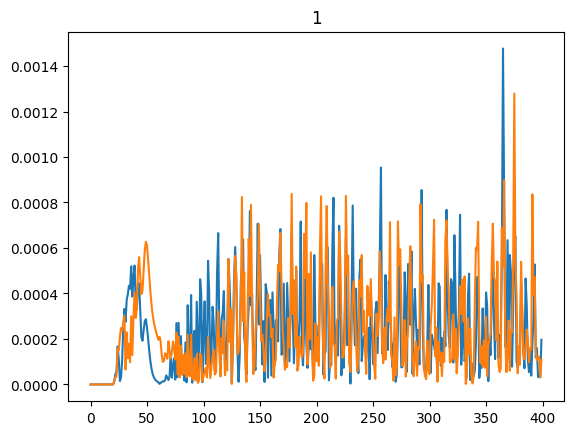

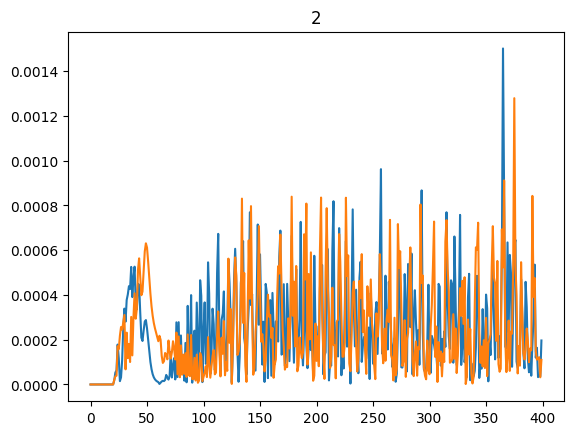

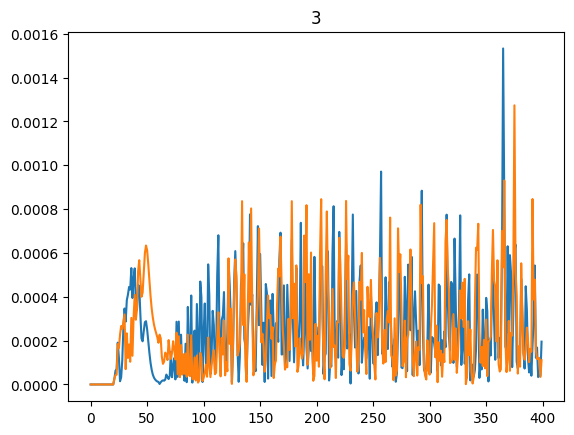

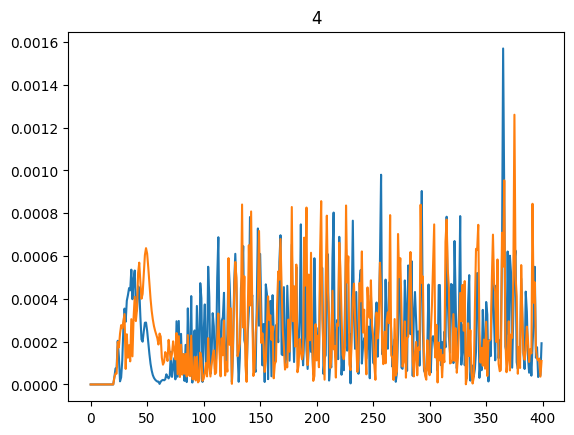

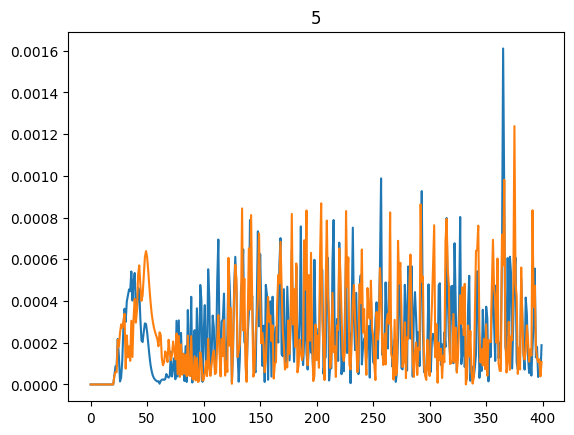

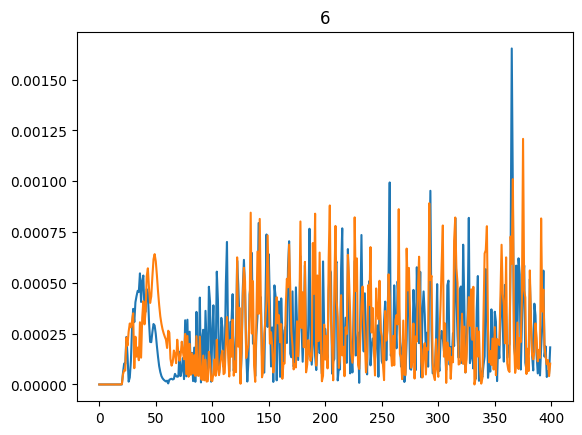

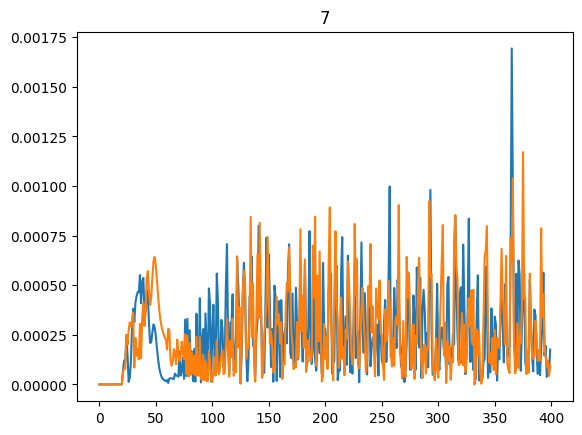

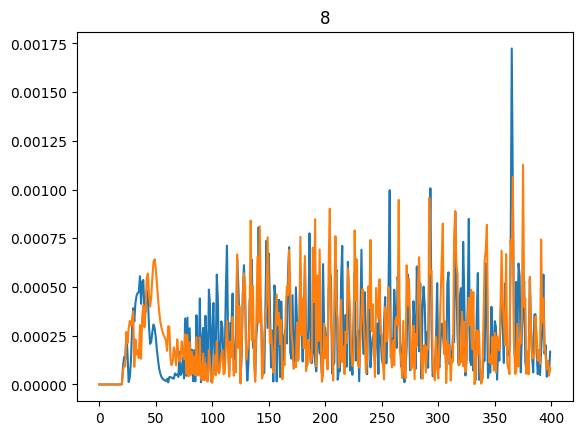

KeyboardInterrupt: 

In [43]:
for i in range(1,10):

    results_df = pd.read_csv(f'C:/Users/Ravil/source/repos/matmod_lab3/matmod_lab3/task4/{i}_res.out', index_col=False)
    checkp_cnt = (results_df.shape[1]-1)//2

    _v = results_df.loc[1:4].to_numpy()[::,2::2]
    _q = results_df.loc[1:4].to_numpy()[::,1::2]
    dq = (_q[1:] - _q[:-1])
    fpu_vals = FPU(dq )
    pot_en = fpu_vals[:-1] + fpu_vals[1:]
    kin_en = _v[1:-1]*_v[1:-1]*0.5
    full_en = pot_en + kin_en
    plt.title(f'{i}')
    for j in range(full_en.shape[0]):
        plt.plot(full_en[j,:full_en.shape[1]//5])
    plt.show()

In [50]:
for i in range(6,10):

    results_df = pd.read_csv(f'C:/Users/Ravil/source/repos/matmod_lab3/matmod_lab3/task4/{i}_res.out', index_col=False)
    checkp_cnt = (results_df.shape[1]-1)//2

    screen = viz_2(results_df[f'v_{0}'].to_numpy(), 1000000)
    cv2.imshow(f'i = {i}', screen)
    t_step = 100
    for j in range(1,checkp_cnt,1):
        screen = viz_2(results_df[f'v_{j}'].to_numpy(), 1000000 + j*t_step)
        cv2.imshow(f'i = {i}', screen)
        if cv2.waitKey(30) == ord('q'):
            break

    cv2.waitKey(3000)
    cv2.destroyAllWindows()

In [33]:
results_df = pd.read_csv(f'./anima_res.out', index_col=False)
checkp_cnt = (results_df.shape[1]-1)//2

screen = viz_2(results_df[f'v_{0}'].to_numpy(), 0)
cv2.imshow(f'0.5', screen)

for j in range(1,checkp_cnt,10):
    screen = viz_2(results_df[f'v_{j}'].to_numpy(), j)
    cv2.imshow(f'0.5', screen)
    if cv2.waitKey(10) == ord('q'):
        break

cv2.waitKey(3000)
cv2.destroyAllWindows()

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - putText() missing required argument 'org' (pos 3)
>  - putText() missing required argument 'org' (pos 3)
